<a href="https://colab.research.google.com/github/WoradeeKongthong/image_classification/blob/master/cat_or_not_image_binary_classification_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import h5py
import numpy as np

# Load dataset

In [ ]:
train_dataset = h5py.File('train_catvnoncat.h5', 'r')
test_dataset = h5py.File('test_catvnoncat.h5', 'r')

In [ ]:
type(train_dataset)

h5py._hl.files.File

In [ ]:
print(list(train_dataset.keys()))
print(list(test_dataset.keys()))

['list_classes', 'train_set_x', 'train_set_y']
['list_classes', 'test_set_x', 'test_set_y']


In [ ]:
trainX = np.array(train_dataset['train_set_x'])
trainy = np.array(train_dataset['train_set_y'])
testX = np.array(test_dataset['test_set_x'])
testy = np.array(test_dataset['test_set_y'])

In [ ]:
# summary dataset shape
print('trainX shape : ', trainX.shape)
print('trainy shape : ', trainy.shape)
print('testX shape : ', testX.shape)
print('testy shape : ', testy.shape)

trainX shape :  (209, 64, 64, 3)
trainy shape :  (209,)
testX shape :  (50, 64, 64, 3)
testy shape :  (50,)


In [ ]:
trainX[0].dtype

dtype('uint8')

In [ ]:
from matplotlib import pyplot as plt
from random import randint

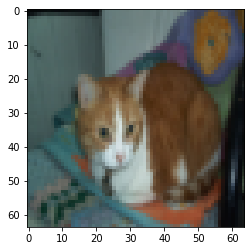

Cat or NonCat :  1


In [ ]:
# print example image and label
sample = randint(0,len(trainX)-1)
plt.imshow(trainX[sample])
plt.show()
print('Cat or NonCat : ', trainy[sample])

# Create Data Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# create generator
datagen = ImageDataGenerator(featurewise_center=True)
datagen.mean = [123.68, 116.779, 103.939]

# prepare iterator
train_it = datagen.flow(trainX, trainy, batch_size=10)
test_it = datagen.flow(testX, testy, batch_size=10)

# Baseline Model : Transfer Learning with VGG16
VGG16 as an integrated feature extractor

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD

In [ ]:
# define model
def baseline_model():
  # load vgg16
  model = VGG16(include_top=False, input_shape=(64,64,3))
  # mark loaded layers as not trainable
  for layer in model.layers :
    layer.trainable = False
  
  # add classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(fc1)

  # define model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = baseline_model()

# Fit the model

In [ ]:
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=10)

Epoch 1/10
21/21 [==============================] - 11s 517ms/step - loss: 2.3753 - accuracy: 0.8708 - val_loss: 3.8834 - val_accuracy: 0.9200
Epoch 2/10
21/21 [==============================] - 11s 510ms/step - loss: 0.3278 - accuracy: 0.9713 - val_loss: 4.0763 - val_accuracy: 0.8600
Epoch 3/10
21/21 [==============================] - 11s 513ms/step - loss: 0.0251 - accuracy: 0.9952 - val_loss: 2.7275 - val_accuracy: 0.9200
Epoch 4/10
21/21 [==============================] - 11s 511ms/step - loss: 7.1933e-05 - accuracy: 1.0000 - val_loss: 3.0634 - val_accuracy: 0.9200
Epoch 5/10
21/21 [==============================] - 11s 528ms/step - loss: 6.2812e-05 - accuracy: 1.0000 - val_loss: 3.0986 - val_accuracy: 0.9200
Epoch 6/10
21/21 [==============================] - 11s 510ms/step - loss: 5.4026e-05 - accuracy: 1.0000 - val_loss: 3.1007 - val_accuracy: 0.9200
Epoch 7/10
21/21 [==============================] - 11s 515ms/step - loss: 4.6827e-05 - accuracy: 1.0000 - val_loss: 3.1001 - val_

# Results : learning curve and model performance

In [ ]:
# plot learning curve and print model performance
def summarize_model(history):
  # learning curve
  plt.figure(figsize=(8,8))

  # plot loss
  plt.subplot(211)
  plt.plot(history.history['loss'], color='green', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='validation')
  plt.title('Cross Entropy Loss')
  plt.legend()

  # plot accuracy
  plt.subplot(212)
  plt.plot(history.history['accuracy'], color='green', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='validation')
  plt.title('Classification Accuracy')
  plt.legend()
  plt.show()
  
  # model performance
  _, train_acc = model.evaluate(train_it, steps=len(train_it), verbose=0)
  _, test_acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('Model Performance (accuracy)')
  print('Train : %.3f' %train_acc)
  print('Test :  %.3f' %test_acc)

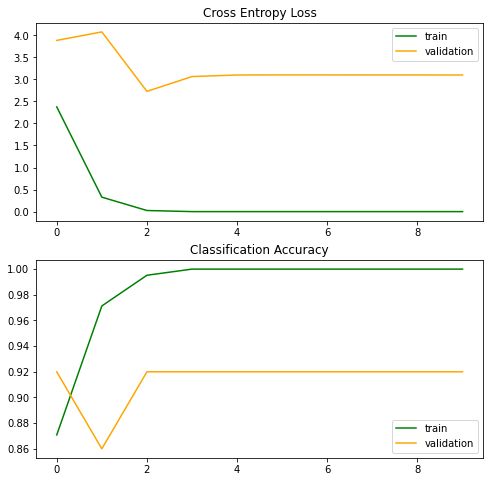

Model Performance (accuracy)
Train : 1.000
Test :  0.920


In [ ]:
summarize_model(history)

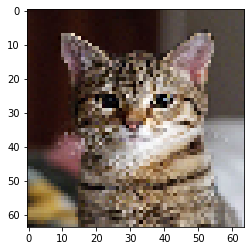

(1, 64, 64, 3)
[[1.]]


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
img = load_img('cat.jpg', target_size=(64, 64))
plt.imshow(img)
plt.show()

sample = img_to_array(img)
sample = np.expand_dims(sample, axis=0)
print(sample.shape)

sample_it = datagen.flow(sample, batch_size=1)
ypred = model.predict_generator(sample_it)
print(ypred)

# Develop model01 : add Dropout layer

In [ ]:
from keras.layers import Dropout

In [ ]:
# define model
def model01():
  # load vgg16
  model = VGG16(include_top=False, input_shape=(64,64,3))
  # mark loaded layers as not trainable
  for layer in model.layers :
    layer.trainable = False
  
  # add classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout1 = Dropout(0.2)(fc1)
  output = Dense(1, activation='sigmoid')(dropout1)

  # define model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/10
21/21 [==============================] - 11s 518ms/step - loss: 2.4588 - accuracy: 0.8517 - val_loss: 3.5032 - val_accuracy: 0.8800
Epoch 2/10
21/21 [==============================] - 11s 511ms/step - loss: 0.7497 - accuracy: 0.9474 - val_loss: 4.7718 - val_accuracy: 0.8800
Epoch 3/10
21/21 [==============================] - 11s 509ms/step - loss: 0.0783 - accuracy: 0.9856 - val_loss: 2.1992 - val_accuracy: 0.9200
Epoch 4/10
21/21 [==============================] - 11s 510ms/step - loss: 0.1408 - accuracy: 0.9809 - val_loss: 2.7222 - val_accuracy: 0.9400
Epoch 5/10
21/21 [==============================] - 11s 508ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.6219 - val_accuracy: 0.9400
Epoch 6/10
21/21 [==============================] - 11s 509ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2.5945 - val_accuracy: 0.9400
Epoch 7/10
21/21 [==============================] - 11s 508ms/step - loss: 1.3539e-05 - accuracy: 1.0000 - val_loss: 2.5827 - val_accuracy: 0.

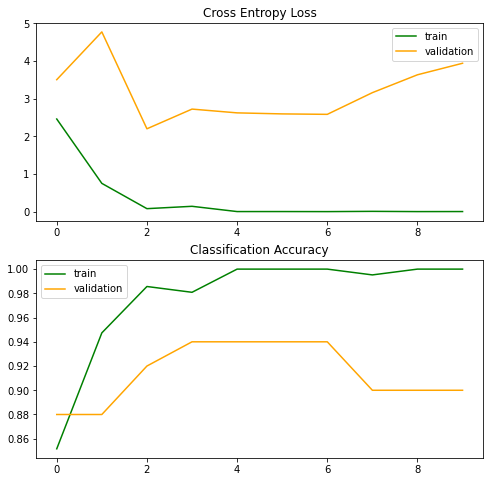

Model Performance (accuracy)
Train : 1.000
Test :  0.900


In [ ]:
model = model01()
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=10)
summarize_model(history)

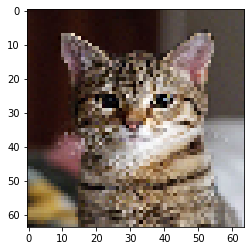

(1, 64, 64, 3)
[[1.]]


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
img = load_img('cat.jpg', target_size=(64, 64))
plt.imshow(img)
plt.show()

sample = img_to_array(img)
sample = np.expand_dims(sample, axis=0)
print(sample.shape)

sample_it = datagen.flow(sample, batch_size=1)
ypred = model.predict_generator(sample_it)
print(ypred)

# Develop model02 : additional fully connected layer and dropout

In [ ]:
# define model
def model02():
  # load vgg16
  model = VGG16(include_top=False, input_shape=(64,64,3))
  # mark loaded layers as not trainable
  for layer in model.layers :
    layer.trainable = False
  
  # add classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout1 = Dropout(0.2)(fc1)
  fc2 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout1)
  dropout2 = Dropout(0.2)(fc2)
  output = Dense(1, activation='sigmoid')(dropout2)

  # define model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/10
21/21 [==============================] - 11s 520ms/step - loss: 2.1579 - accuracy: 0.8373 - val_loss: 0.7174 - val_accuracy: 0.9200
Epoch 2/10
21/21 [==============================] - 11s 509ms/step - loss: 0.7608 - accuracy: 0.9282 - val_loss: 1.2264 - val_accuracy: 0.9400
Epoch 3/10
21/21 [==============================] - 11s 511ms/step - loss: 0.5597 - accuracy: 0.9522 - val_loss: 1.8170 - val_accuracy: 0.9400
Epoch 4/10
21/21 [==============================] - 11s 511ms/step - loss: 0.2483 - accuracy: 0.9713 - val_loss: 2.0380 - val_accuracy: 0.9200
Epoch 5/10
21/21 [==============================] - 11s 511ms/step - loss: 0.0160 - accuracy: 0.9904 - val_loss: 1.7233 - val_accuracy: 0.9200
Epoch 6/10
21/21 [==============================] - 11s 510ms/step - loss: 0.1547 - accuracy: 0.9856 - val_loss: 1.9239 - val_accuracy: 0.9200
Epoch 7/10
21/21 [==============================] - 11s 512ms/step - loss: 0.0481 - accuracy: 0.9904 - val_loss: 2.1557 - val_accuracy: 0.9200

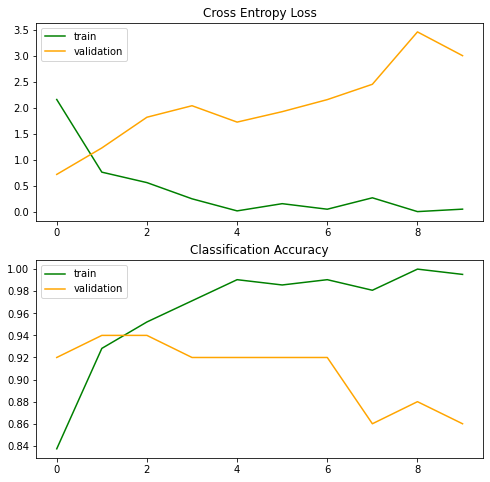

Model Performance (accuracy)
Train : 1.000
Test :  0.860


In [ ]:
model = model02()
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=10)
summarize_model(history)

Note : additional fully connected layer doesn't help on increasing performance

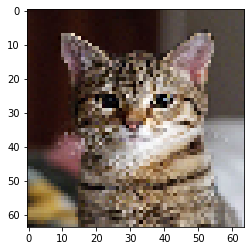

(1, 64, 64, 3)
[[1.]]


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
img = load_img('cat.jpg', target_size=(64, 64))
plt.imshow(img)
plt.show()

sample = img_to_array(img)
sample = np.expand_dims(sample, axis=0)
print(sample.shape)

sample_it = datagen.flow(sample, batch_size=1)
ypred = model.predict_generator(sample_it)
print(ypred)

# Improve model03 : change flatten to be global average pooling

In [ ]:
# define model
def model03():
  # load vgg16
  model = VGG16(include_top=False, input_shape=(64,64,3), pooling='avg')
  # mark loaded layers as not trainable
  for layer in model.layers :
    layer.trainable = False
  
  # add classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout1 = Dropout(0.2)(fc1)
  output = Dense(1, activation='sigmoid')(dropout1)

  # define model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/10
21/21 [==============================] - 11s 520ms/step - loss: 2.2798 - accuracy: 0.8230 - val_loss: 1.7876 - val_accuracy: 0.9400
Epoch 2/10
21/21 [==============================] - 11s 521ms/step - loss: 0.2716 - accuracy: 0.9665 - val_loss: 2.5607 - val_accuracy: 0.9200
Epoch 3/10
21/21 [==============================] - 11s 507ms/step - loss: 0.4034 - accuracy: 0.9713 - val_loss: 1.9927 - val_accuracy: 0.9000
Epoch 4/10
21/21 [==============================] - 11s 509ms/step - loss: 0.0748 - accuracy: 0.9856 - val_loss: 1.8862 - val_accuracy: 0.9000
Epoch 5/10
21/21 [==============================] - 11s 507ms/step - loss: 0.0878 - accuracy: 0.9856 - val_loss: 1.9154 - val_accuracy: 0.9400
Epoch 6/10
21/21 [==============================] - 11s 509ms/step - loss: 0.0595 - accuracy: 0.9904 - val_loss: 1.9548 - val_accuracy: 0.9400
Epoch 7/10
21/21 [==============================] - 11s 514ms/step - loss: 0.0218 - accuracy: 0.9904 - val_loss: 1.8637 - val_accuracy: 0.9000

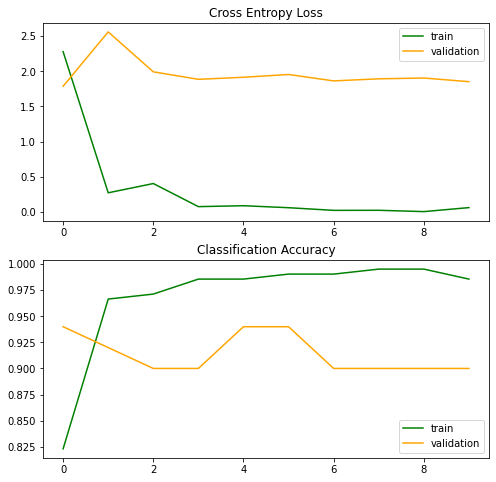

Model Performance (accuracy)
Train : 1.000
Test :  0.900


In [ ]:
model = model03()
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=10)
summarize_model(history)

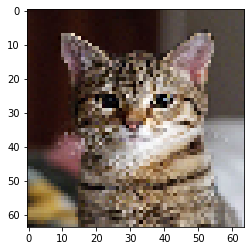

(1, 64, 64, 3)
[[1.]]


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
img = load_img('cat.jpg', target_size=(64, 64))
plt.imshow(img)
plt.show()

sample = img_to_array(img)
sample = np.expand_dims(sample, axis=0)
print(sample.shape)

sample_it = datagen.flow(sample, batch_size=1)
ypred = model.predict_generator(sample_it)
print(ypred)

# Develop model04 : set last VGG-block as trainable

In [ ]:
model=VGG16(include_top=False, input_shape=(64,64,3), pooling='avg')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
# define model
def model04():
  # load vgg16
  model = VGG16(include_top=False, input_shape=(64,64,3), pooling='avg')
  # mark loaded layers as not trainable
  for layer in model.layers[:-5] :
    layer.trainable = False
  
  # add classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout1 = Dropout(0.2)(fc1)
  output = Dense(1, activation='sigmoid')(dropout1)

  # define model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/20
21/21 [==============================] - 15s 692ms/step - loss: 21.6482 - accuracy: 0.7033 - val_loss: 2457.0020 - val_accuracy: 0.3400
Epoch 2/20
21/21 [==============================] - 14s 687ms/step - loss: nan - accuracy: 0.5885 - val_loss: nan - val_accuracy: 0.3400
Epoch 3/20
21/21 [==============================] - 14s 685ms/step - loss: nan - accuracy: 0.6555 - val_loss: nan - val_accuracy: 0.3400
Epoch 4/20
21/21 [==============================] - 14s 686ms/step - loss: nan - accuracy: 0.6555 - val_loss: nan - val_accuracy: 0.3400
Epoch 5/20
21/21 [==============================] - 14s 684ms/step - loss: nan - accuracy: 0.6555 - val_loss: nan - val_accuracy: 0.3400
Epoch 6/20
21/21 [==============================] - 14s 684ms/step - loss: nan - accuracy: 0.6555 - val_loss: nan - val_accuracy: 0.3400
Epoch 7/20
21/21 [==============================] - 14s 686ms/step - loss: nan - accuracy: 0.6555 - val_loss: nan - val_accuracy: 0.3400
Epoch 8/20
21/21 [=============

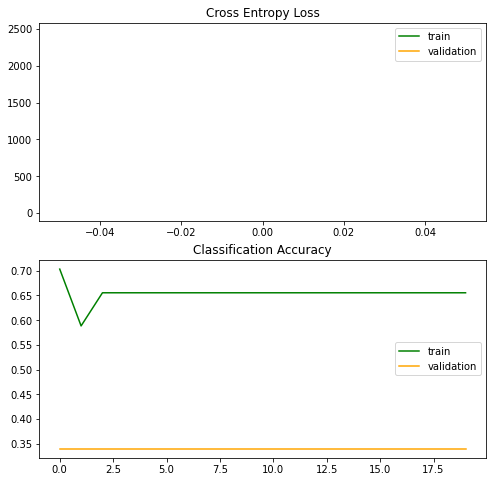

Model Performance (accuracy)
Train : 0.656
Test :  0.340


In [ ]:
model = model04()
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20)
summarize_model(history)

# Develop model05 : Data Augmentation

In [ ]:
# define model
def model05():
  # create train data generator
  train_datagen = ImageDataGenerator(featurewise_center=True, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, rotation_range=90)
  train_datagen.mean = [123.68, 116.779, 103.939]

  # create test data generator (no data augmentation)
  test_datagen = ImageDataGenerator(featurewise_center=True)
  test_datagen.mean = [123.68, 116.779, 103.939]

  # prepare iterator
  train_it = train_datagen.flow(trainX, trainy, batch_size=10)
  test_it = test_datagen.flow(testX, testy, batch_size=10)
  
  # load vgg16
  model = VGG16(include_top=False, input_shape=(64,64,3), pooling='avg')
  # mark loaded layers as not trainable
  for layer in model.layers :
    layer.trainable = False

  # add classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout1 = Dropout(0.2)(fc1)
  output = Dense(1, activation='sigmoid')(dropout1)

  # define model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/20
21/21 [==============================] - 11s 526ms/step - loss: 2.1633 - accuracy: 0.7751 - val_loss: 1.6320 - val_accuracy: 0.8800
Epoch 2/20
21/21 [==============================] - 11s 518ms/step - loss: 0.7224 - accuracy: 0.8804 - val_loss: 1.9351 - val_accuracy: 0.9000
Epoch 3/20
21/21 [==============================] - 11s 518ms/step - loss: 0.7383 - accuracy: 0.9330 - val_loss: 1.5191 - val_accuracy: 0.9200
Epoch 4/20
21/21 [==============================] - 11s 518ms/step - loss: 0.3608 - accuracy: 0.9330 - val_loss: 1.5762 - val_accuracy: 0.8800
Epoch 5/20
21/21 [==============================] - 11s 518ms/step - loss: 0.1967 - accuracy: 0.9522 - val_loss: 1.7505 - val_accuracy: 0.9200
Epoch 6/20
21/21 [==============================] - 11s 517ms/step - loss: 0.1380 - accuracy: 0.9713 - val_loss: 1.7205 - val_accuracy: 0.8800
Epoch 7/20
21/21 [==============================] - 11s 519ms/step - loss: 0.1577 - accuracy: 0.9761 - val_loss: 2.1621 - val_accuracy: 0.8600

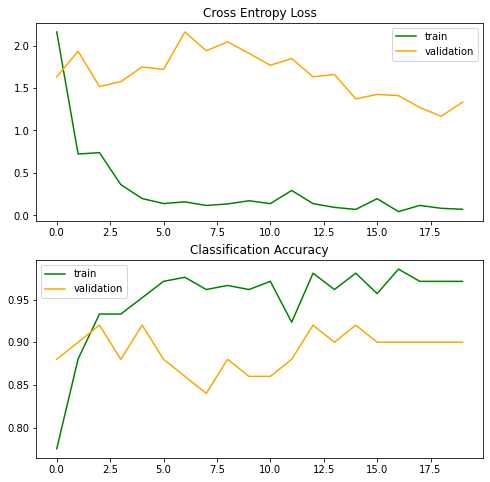

Model Performance (accuracy)
Train : 0.971
Test :  0.900


In [ ]:
model = model05()
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20)
summarize_model(history)

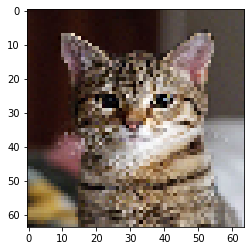

(1, 64, 64, 3)
[[1.]]


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
img = load_img('cat.jpg', target_size=(64, 64))
plt.imshow(img)
plt.show()

sample = img_to_array(img)
sample = np.expand_dims(sample, axis=0)
print(sample.shape)

sample_it = datagen.flow(sample, batch_size=1)
ypred = model.predict_generator(sample_it)
print(ypred)

# Finalize and Save the model
Selected model : baseline model  
Finalize the model : fit the model with entire training set  
Save the model as .h5 

In [ ]:
model = baseline_model()
model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=20)
# Save the Model
model.save('final_model.h5')

Epoch 1/20
21/21 [==============================] - 9s 407ms/step - loss: 1.8944 - accuracy: 0.8708
Epoch 2/20
21/21 [==============================] - 9s 408ms/step - loss: 0.3310 - accuracy: 0.9713
Epoch 3/20
21/21 [==============================] - 9s 408ms/step - loss: 0.1814 - accuracy: 0.9761
Epoch 4/20
21/21 [==============================] - 9s 408ms/step - loss: 0.0654 - accuracy: 0.9904
Epoch 5/20
21/21 [==============================] - 9s 412ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 6/20
21/21 [==============================] - 9s 407ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 7/20
21/21 [==============================] - 9s 408ms/step - loss: 1.0933e-05 - accuracy: 1.0000
Epoch 8/20
21/21 [==============================] - 9s 408ms/step - loss: 9.0927e-06 - accuracy: 1.0000
Epoch 9/20
21/21 [==============================] - 9s 408ms/step - loss: 8.8338e-06 - accuracy: 1.0000
Epoch 10/20
21/21 [==============================] - 9s 410ms/step - loss: 8.6269e-06 - 

# Prediction
Make a prediction on a single image with the saved final model

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

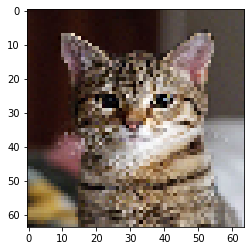

(64, 64, 3)


In [ ]:
# load image
img = load_img('cat.jpg', target_size=(64, 64))
# plot image
plt.imshow(img)
plt.show()

# convert image to array
img = img_to_array(img)
print(img.shape)

In [ ]:
# reshape image to single sample with 1 channel
sample = img.reshape(1,64,64,3)

# create generator without data augmentation
datagen = ImageDataGenerator(featurewise_center=True)
datagen.mean = [123.68, 116.779, 103.939]

# prepare iterator
sample_it = datagen.flow(sample, batch_size=1)

# load model
model = load_model('final_model.h5')

# make prediction
result = model.predict(sample_it)
print('prediction : ', result[0])

prediction :  [1.]
